# Libraries

In [92]:
import numpy as np
import numpy.random as rnd
import numpy.linalg
import matplotlib.pyplot as plt
from numpy import linalg as LA
from numpy.random import normal
import scipy
from scipy.spatial.transform import Rotation as R
from scipy.optimize import minimize

In [93]:


class Configuration:
    #"""generate a configuration of spins"""
    
    def __init__(self, a,theta,Nx,Ny, J,config):
        #'we create a kagome lattice from parameter a and theta with Nx*Ny*3 spins , '
        self.a,self.theta,self.Nx,self.Ny,self.J=a,theta,Nx,Ny,J
        self.N=Nx*Ny

        # a_1 and a_2 are the lattice translation generating vectors 
        a_1=a*np.array([1,0])
        a_2=a*np.array([-1*np.cos(theta),np.sin(theta)])
        
        # we construct the unit cell
        unit_cell=np.array([[0,0],0.5*a_2,0.5*a_1])
        
        # we construct the grid points from the translations of the lattice
        self.x_l,self.y_l=np.meshgrid(range(Nx),range(Ny))
        A_1=np.tensordot(self.y_l,[a_1,a_1,a_1],axes=0)
        A_2=np.tensordot(self.x_l,[a_2,a_2,a_2],axes=0)

        # the lattice points coordinates are created from adding a unit cell at each grid point
        self.lattice=np.tensordot(np.ones((Nx,Ny)),unit_cell,axes=0)+A_1+A_2

        # we create a dim object containing the dimensions of the lattice 
        dim=self.lattice.shape

        
        self.config=config
        

  


    def get_energy(self,i,j,s):
        """this part implements the sommation over spins nearest spins"""
        
        # spin that we want to calculate the contribution to the energy
        S=np.array(self.config[i,j,s,:])

        # from the kernel lookup list we see the nearest coordinates
        kernel=np.mod([[[i,j-1,1],[i-1,j,2]],[[i-1,j+1,2],[i,j+1,0]],[[i+1,j-1,1],[i+1,j,0]]],[self.Nx,self.Ny,3])
        # we add the nearest spins
        S_nearest=np.array(self.config[i,j,(s+1)%3,:]+self.config[i,j,(s+2)%3,:])
        S_nearest+=np.array(self.config[kernel[s,0,0],kernel[s,0,1],kernel[s,0,2],:]+self.config[kernel[s,1,0],kernel[s,1,1],kernel[s,1,2],:])
        # we compute the dot product and thus this spin contribution to the energy 
        E=(self.J)*np.dot(S,S_nearest)
        return E



    def total_energy(self):
        """ this part implements the summation of energy over the whole lattice"""

        E=0
        # we sum over each grid point 
        for i in range(self.Nx):
            for j in range(self.Ny):
                for s in range(3):
                    #we compute each spin contribution
                    E=E+self.get_energy(i,j,s)
        print(E/(2*self.N))
        return E/(2*self.N) # we divide by 2 because ech vertex is summed twice


    def delta_energy(self,i,j,s):
        ''' this function is used to compute the energy difference for a flip '''
 
        # we compute the sum of the nearest neighbors of the spin that could be flipped
        kernel=np.mod([[[i,j-1,1],[i-1,j,2]],[[i-1,j+1,2],[i,j+1,0]],[[i+1,j-1,1],[i+1,j,0]]],[self.Nx,self.Ny,3])
        S_nearest=np.array(self.config[i,j,(s+1)%3,:]+self.config[i,j,(s+2)%3,:])
        S_nearest+=np.array(self.config[kernel[s,0,0],kernel[s,0,1],kernel[s,0,2],:]+self.config[kernel[s,1,0],kernel[s,1,1],kernel[s,1,2],:])


        #we compute the difference in energy contribution between the flipped and unaltered spin
        Delta_E=(self.J)*np.dot(self.flipped_spin-self.config[i,j,s,:],S_nearest)

        
        return Delta_E


    def magnetisation(self):
        print(np.linalg.norm([np.sum(self.config[:,:,:,0]),np.sum(self.config[:,:,:,1]),np.sum(self.config[:,:,:,2])])/self.N)
        
  

    

    def display_config(self):

        ax = plt.figure().add_subplot(projection='3d')
        ax.set_ylim(-self.a,self.a*self.Ny)
        ax.set_xlim(-self.a,self.a*(self.Nx+2))
        ax.set_zlim(-1,1)

        position=np.reshape(self.lattice,(3*self.Nx*self.Ny,2),order='C')
        arrows=np.reshape(self.config,(3*self.Nx*self.Ny,3),order='C')

        # Make the grid
        x, y, z = position[:,0],position[:,1],np.zeros((3*self.Nx*self.Ny))

        # Make the direction data for the arrows
        u = arrows[:,0]
        v = arrows[:,1]
        w = arrows[:,2]
        
        ax.quiver(x,y,z, u, v, w, length=1, normalize=False,pivot='tail')

        ax.view_init(elev=0, azim=0, roll=0)
        
        plt.show()
        #ax = plt.figure().add_subplot(projection='3d')

        ax.quiver(x,y,z, u, v, w, length=1, normalize=False,pivot='tail')
        ax.view_init(elev=0, azim=90, roll=0)


        plt.show()

        ax2 = plt.figure().add_subplot(projection='3d')
        ax2.set_ylim(-self.a,self.a*(self.Ny))
        ax2.set_xlim(-self.a,self.a*(self.Nx+2))
        ax2.set_zlim(-1,1)
        

        ax2.quiver(x,y,z, u, v, w, length=1, normalize=False,pivot='tail')
        
        ax2.view_init(elev=90, azim=90, roll=0)


        plt.show()

    def spin_realign(self):

        ax = plt.figure().add_subplot(projection='3d')

        ax.set_ylim(-self.a,self.a*self.Ny)
        ax.set_xlim(-self.a,self.a*(self.Nx+2))
        ax.set_zlim(-1,1)

        position=np.reshape(self.lattice,(3*self.Nx*self.Ny,2),order='C')
        arrows=np.reshape(self.config,(3*self.Nx*self.Ny,3),order='C')

        


        Avg=np.mean(arrows,axis=0)
        Avg/=np.linalg.norm(Avg)
        print(Avg)

        def f(q,Avg=Avg):
            q/=np.linalg.norm(q)
            r=R.from_quat(q)
            newavg = r.apply(Avg)
            return newavg[2]**2

        res=minimize(f,np.array([1,1,1,1]), method='nelder-mead')
        r=R.from_quat(res.x)
        arrows=r.apply(arrows,inverse=False)

        newavg=np.mean(arrows,axis=0)/np.linalg.norm(np.mean(arrows,axis=0))

        print(newavg)


        
        """ A0=arrows[0]
        for k in arrows[1:]:
            A0=np.cross(A0,k)

            A0/=np.linalg.norm(A0)
        print(A0)

        def f(q,A0=A0):
            q/=np.linalg.norm(q)
            r=R.from_quat(q)
            newA0 = r.apply(A0)
            return 1-newA0[2]**2

        res=minimize(f,np.array([1,1,1,1]), method='nelder-mead')
        r=R.from_quat(res.x)
        arrows=r.apply(arrows,inverse=False)

        newA0=r.apply(A0,inverse=False)

        print(newA0) """

        #print(np.mean(arrows,axis=0)/np.linalg.norm(np.mean(arrows,axis=0)))
        # Make the grid
        x, y, z = position[:,0],position[:,1],np.zeros((3*self.Nx*self.Ny))

        # Make the direction data for the arrows
        u = arrows[:,0]
        v = arrows[:,1]
        w = arrows[:,2]

        
        ax.quiver(x,y,z, u, v, w, length=1, normalize=False,pivot='tail')
        ax.view_init(elev=0, azim=0, roll=0)
        plt.show()

        #ax = plt.figure().add_subplot(projection='3d')

        ax3 = plt.figure().add_subplot(projection='3d')

        ax3.set_ylim(-self.a,self.a*self.Ny)
        ax3.set_xlim(-self.a,self.a*(self.Nx+2))
        ax3.set_zlim(-1,1)
        ax3.quiver(x,y,z, u, v, w, length=1, normalize=False,pivot='tail')
        ax3.view_init(elev=0, azim=90, roll=0)


        plt.show()

        ax2 = plt.figure().add_subplot(projection='3d')
        ax2.set_ylim(-self.a,self.a*(self.Ny))
        ax2.set_xlim(-self.a,self.a*(self.Nx+2))
        ax2.set_zlim(-1,1)
        

        ax2.quiver(x,y,z, u, v, w, length=1, normalize=False,pivot='tail')
        
        ax2.view_init(elev=90, azim=90, roll=0)


        plt.show()
    def verify_norm(self):
        """ we have sometimes a problem with the  spin vectors not 
        being normalised after too many rotations due to errors so we normalise them after each 
        flip and we verify their maximum norms"""
        print('norm=',LA.norm(self.config,axis=0).max())


    def saveconfig(self,title):
        np.save(title, self.config)



-1.5046096824249031
0.06817758296435804
[-0.57965413  0.78591683 -0.21525758]
[-6.54908997e-01 -7.55707751e-01  9.35602498e-07]


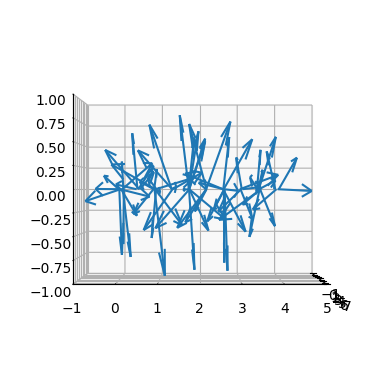

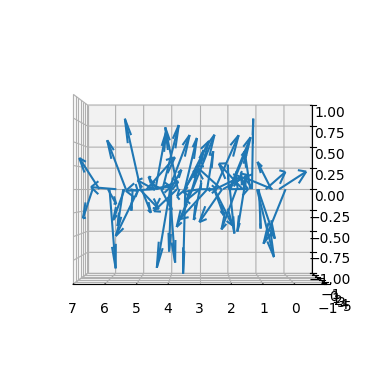

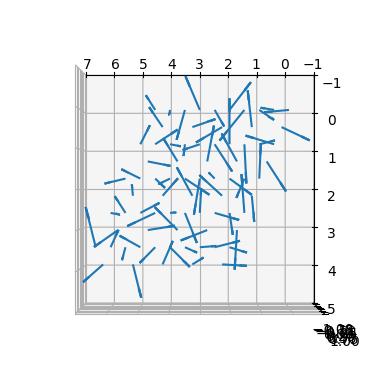

In [94]:

config=np.load("/home/thau/Downloads/VScodium/my_venv/Project1_3_NumericalPhs/Design/smallverconfigtestT-3.npy")
J=1
#kb=1.38*10**-23
T=[10**-5,10**-4,10**-3]
#T=[10**-5,10**-4,10**-3,10**-2,10**-1]

Nx=config.shape[0]
Ny=config.shape[1]
theta=2*np.pi/3
a=1


N=Nx*Ny*3


A=Configuration(1,theta,Nx,Ny,J,config)
A.total_energy()
A.magnetisation()
A.spin_realign()

